# Loading

In [1]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
# import pandas_datareader as web
import datetime as dt

# ML/DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed,GRU,Embedding
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
import json
seed(1)

In [2]:
filepath='model2/'

In [3]:
train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)
data_oil = pd.read_csv('oil.csv')
samp_subm = pd.read_csv('sample_submission.csv')
data_holi = pd.read_csv('holidays_events.csv')
data_store =  pd.read_csv('stores.csv')
data_trans = pd.read_csv('transactions.csv')


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
## holiday 重複的部分做處理
#  type：{'holiday':3,'transfer':4,'addition:'0','bridge':1,'work day':5,'event':2} nan=6
#  local:{'local':0,'region':2,'nation':1} nan=3
data_holi = data_holi[['date','type','locale']]
ordinal_encoder = OrdinalEncoder()
c = ['type','locale']
data_holi[c] = ordinal_encoder.fit_transform(data_holi[c])
data_holi[c]=data_holi[c].astype(int)
data_holi = data_holi.groupby(['date'],as_index=False).agg({'type':'mean','locale':'first'})

In [5]:
all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data['date'] =  pd.to_datetime(all_data['date'])
data_holi['date'] = pd.to_datetime(data_holi['date'])
data_oil['date'] = pd.to_datetime(data_oil['date'])

In [6]:
df_train1 = all_data.merge(data_holi, on = 'date', how='left')
df_train1 = df_train1.merge(data_oil, on = 'date', how='left')
df_train1 = df_train1.merge(data_store, on = 'store_nbr', how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})
df_train1['day_of_week'] = df_train1['date'].dt.day_name()


In [7]:

# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df['week'] = df['date'].dt.isocalendar().week
# df['quarter'] = df['date'].dt.quarter


train_columns = ['date','store_nbr','family','sales','onpromotion','holiday_type','locale','dcoilwtico','store_type','cluster','day_of_week']
df = df_train1[train_columns]

In [8]:
num_test,num_train = len(test_data),len(train_data)

In [9]:
df_copy = df.copy()

# EDA
df = train + test

### 圖示化


In [10]:

# buf = df[['date','store_nbr','sales','family']].groupby(['store_nbr','family','date'],as_index = False).agg({"sales":"mean"})
# store = []
# for i in range(1,55):
#     f = list(buf[buf['store_nbr']==i].drop(columns = ['store_nbr']).groupby(['family']))
#     store1 = f[0][1].drop(columns=['family'])
#     for i in range(1,33):
#         store1 = store1.merge(f[i][1].drop(columns=['family']), on = 'date', how='left')
#         store1 = store1.rename(columns = {"sales_x": "sales" ,"sales_y" : f[i][0]})
#     store1 = store1.rename(columns = {"sales": f[0][0]})  
#     store.append(store1)


### Transform

In [11]:
df =df_copy.copy()

In [12]:
# df.info()

In [13]:
# df.isnull().sum()

In [14]:
df['holiday_type'].fillna(6,inplace=True)
df['locale'].fillna(3,inplace=True)
df['dcoilwtico'].fillna(df['dcoilwtico'].mean(),inplace=True)
# df.isnull().sum()

In [15]:
object_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
number_cols = [cname for cname in df.columns if df[cname].dtype!="object" and cname!='date']
# buf[col] = ordinal_encoder.fit_transform(buf[col])
print(object_cols,number_cols)

['family', 'store_type', 'day_of_week'] ['store_nbr', 'sales', 'onpromotion', 'holiday_type', 'locale', 'dcoilwtico', 'cluster']


In [16]:
ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

### Train Test data

In [17]:
condition ={
    'store_nbr':'mean',#(都一樣)
    'family':'mean',#(都一樣)
    'onpromotion':'mean',
    'holiday_type':'mean', #ok
    'locale':'mean',#ok
    'dcoilwtico':'mean',#ok
    'store_type':'mean',#(都一樣)
    'cluster':'mean',
    'day_of_week':'mean'
    }

In [18]:
train_x = df[:num_train].copy()
train_condition = condition.copy()
train_condition['sales'] ='mean'
train_x = train_x.groupby(['date'],as_index=False).agg(train_condition)#ok


In [19]:
# new_buf = pd.DataFrame()
# for i in range(0,33):
#     f = df[df['family']==i]
#     f["sales"] = scaler.fit_transform(f["sales"].values.reshape(-1,1))
#     new_buf = pd.concat([new_buf,f],axis=0)
# df = new_buf.sort_index()
scaler = MinMaxScaler(feature_range=(0,1))
for col in number_cols+object_cols:
    # if col=="sales":continue
    df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

In [20]:

train_y = train_x[['date','sales']]
train_x.drop(columns=['date','sales'],inplace=True)
train_y.drop(columns=['date'],inplace=True)

C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
history_input = 7
train_input = []
train_output = []
for i in range(len(train_x)-history_input+1):
    train_input.append(train_x[i:i+history_input].values)
    train_output.append(train_y.iloc[i+history_input-1])
train_input=np.array(train_input)
train_output=np.array(train_output)
# print(x_train_input.shape)
# print(y_train_input.shape)

In [22]:
# def Make_Model_GRU():    

In [23]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    
    # First LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = train_input[0].shape )) 
    model.add(Dropout(0.2))
    
    # Second LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50,  activation='relu', return_sequences = True))                                    
    model.add(Dropout(0.2))
    
    # Final LSTM layer with Dropout regularisation; Set return_sequences to False since now we will be predicting with the output layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [24]:
model = Multi_Step_LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=2)
history = model.fit(train_input,train_output, validation_split=0.3,batch_size=len(train_input), epochs=100,callbacks=early_stop)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             12000     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5


val_acc: 0.00%


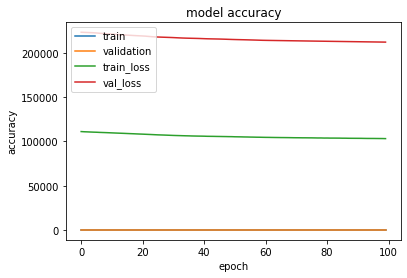

In [25]:
def draw(history):
    val_acc = np.mean(history.history['val_accuracy'])
    print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation','train_loss','val_loss'], loc='upper left')

    # plt.legend(['train','loss'], loc='upper left')
    plt.show()
draw(history)

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open(filepath+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(filepath+"model.json.h5")
print("Saved model to disk")

Saved model to disk


# Perdict

In [27]:
test_x = df[num_train:].copy().drop(columns=['sales'])
test_x = test_x.groupby(['date'],as_index=False).agg(condition)

In [28]:
train_x_buf = df[:num_train].copy().drop(columns=['sales'])
train_x_buf = train_x_buf.groupby(['date'],as_index=False).agg(condition)#ok
test_x = pd.concat([train_x_buf[-1*(history_input):-1],test_x],ignore_index=True)
# print(train_x_buf[-7:-1])

In [29]:
test_input = []
# for i in range(len(test_x)-history_input+1):
#     # test_input.append(test_x[i:i+history_input].values)# show date
#     test_input.append(test_x[i:i+history_input].drop(columns=['date']).values)   
#     end = x_test_mean.index[x_test_mean['date']==x_test['date'].iloc[i]].tolist()[0]
#     start = end - 29
#     x_test_input.append(pd.concat([x_test_mean[start:end].drop(columns=["date"]),x_test[i:i+1].drop(columns=["date","sales"])]).values)
test_ = df[num_train:].copy()
for i in range(len(test_['date'])):
    end = test_x.index[test_x['date']==test_['date'].iloc[i]].tolist()[0]
    start = end - history_input + 1
    test_input.append(pd.concat([test_x[start:end],test_[i:i+1]]).drop(columns=['date','sales']).values)
    # print(start,end)
    # if i==28511:
    #     print(x_test_mean[start:end].drop(columns=["date"]),x_test[i:i+1].drop(columns=["date","sales"]))

test_input=np.array(test_input)
print(test_input.shape)

(28512, 7, 9)


In [30]:
y_pred = model.predict(test_input)
print(y_pred)

[[5.166827 ]
 [5.1675143]
 [5.1681614]
 ...
 [5.108201 ]
 [5.108944 ]
 [5.1100793]]


In [31]:
y_pred = scaler.inverse_transform(y_pred)
print(type(y_pred))

<class 'numpy.ndarray'>


In [32]:
test_data = pd.read_csv('test.csv')
submit = test_data[['id']]
submit['sales'] = y_pred

C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
submit.to_csv(filepath+"submit.csv",index=False,sep=',')
import zipfile
with zipfile.ZipFile(filepath+'submit.zip', 'w') as zf:
    zf.write(filepath+'submit.csv')